### Lattice
* This script allows one to tune the hopping and go from one limit to another

In [15]:
import numpy as np
import seaborn as sns
from itertools import product
from scipy.linalg import eigh
import matplotlib.pyplot as plt

In [16]:
### class to set up the hamiltonian object
class Hamiltonian():

    ## initializer to create an instance of the class
    def __init__(self,L,tab,taa,tbb):
        self.L=L
        self.n_sites = self.L**2
        self.tab = tab
        self.taa = taa
        self.tbb = tbb
      

    ### setting up the neighbors
    def neighbour(self):
        ## increase the site index keeping the periodic boundary condition
        sip = lambda x:(x+1)%self.L
        sim = lambda x:(x-1+self.L)%self.L

        ## array to store the neighboring sites
        right,left,up,down=[],[],[],[]
        right_up,left_down = [],[]
        right_down,left_up = [],[]

        for i in range(self.n_sites):
            xi = i%self.L
            yi = i//self.L
            right.append(sip(xi)+yi*self.L)
            left.append(sim(xi)+yi*self.L)
            up.append(xi+sip(yi)*self.L)
            down.append(xi+sim(yi)*self.L)
            right_up.append(sip(xi)+sip(yi)*self.L)
            left_down.append(sim(xi)+sim(yi)*self.L)
            right_down.append(sim(yi)*self.L + sip(xi))
            left_up.append(sim(xi)+sip(yi)*self.L)    

        self.right  = np.array(right)
        self.left = np.array(left)
        self.up = np.array(up)
        self.down = np.array(down)
        self.right_up = np.array(right_up)
        self.right_down = np.array(right_down)
        self.left_down = np.array(left_down)
        self.left_up = np.array(left_up)

    ### calculating the x,y index of each site 
    ### setting the sublattice structure
    def sublatt_set(self):
        x_index,y_index = [],[]
        sublatt_a,sublatt_b = [],[]
        for i in range(self.n_sites):
            xi =  i%self.L
            yi = i//self.L
            x_index.append(xi)
            y_index.append(yi)
            if ((xi+yi)%2==0):
                sublatt_a.append(i)
            elif((xi+yi)%2!=0):
                sublatt_b.append(i)
        self.xindex = np.array(x_index)
        self.yindex = np.array(y_index)
        self.sublatta = np.array(sublatt_a)
        self.sublattb = np.array(sublatt_b)
    
    ### setting up the hamiltonian for the triangular lattice
    def triangular(self,a):
        for i in range(self.n_sites):
            ## hopping between nearest neighbors
            a[i,self.right[i]] = -self.tab
            a[i,self.left[i]] = -self.tab
            a[i,self.up[i]] = -self.tab
            a[i,self.down[i]] = -self.tab

            ## conjugate hopping between neighbors
            a[self.right[i],i] = -self.tab
            a[self.left[i],i] = -self.tab
            a[self.up[i],i] = -self.tab
            a[self.down[i],i] = -self.tab

            if i in self.sublatta:
                ## hopping between nn neighbors
                a[i,self.right_up[i]]  = -self.taa
                a[i,self.left_down[i]] = -self.taa

                ## conjugate hopping
                a[self.right_up[i],i] = -self.taa
                a[self.left_down[i],i] = -self.taa

            if i in self.sublattb:
                a[i,self.right_up[i]] = -self.tbb
                a[i,self.left_down[i]] = -self.tbb

                a[self.right_up[i],i] = -self.tbb 
                a[self.left_down[i],i] = -self.tbb               

        return a

    ### diagonalize the matrix
    def evals(self,mat):
        self.eval_i,self.evec_i = eigh(mat)


    ### plotting eigenvalue data for the given lattice
    def plot_eval(self, bin=32):
        f, ax = plt.subplots(2, 2, figsize=(10, 6))
        ax[0, 0].plot(np.sort(self.eval_i), marker='o', markersize=1)
        ax[0, 0].set_xlabel('N', fontsize=14)
        ax[0, 0].set_ylabel('E', fontsize=14)

        ax[0, 1].plot(abs(np.sort(self.eval_i)), marker='o', markersize=1)
        ax[0, 1].set_xlabel('N', fontsize=14)
        ax[0, 1].set_ylabel('abs(E)', fontsize=14)

        ax[1, 0].hist(self.eval_i, density=1, bins=bin)
        ax[1, 0].set_xlabel('E', fontsize=14)
        ax[1, 0].set_ylabel('H(E)', fontsize=14)

        ax[1, 1].set_visible(False)
        plt.tight_layout()
        plt.show()


In [17]:
### child class inheriting from the parent class (hamiltonian)
class kagomeLieb(Hamiltonian):
    def __init__(self,L,tab,taa,tbb):
        super().__init__(L,tab,taa,tbb)

    ### triangular to Lieb/Kagome
    ### tmid = 0, ta2a = 0 and finite tb2b will give kagome lattice
    ### tmid = 0 , ta2a = 0, tb2b = 0 will give lieb lattice
    def triangle_Kagome_lieb(self, mat, t_mid, ta2a, tb2b):
        print(f'taa:{ta2a} tbb:{tb2b}')
        for xi, yi in product(np.arange(1, self.L, 2), np.arange(1, self.L, 2)):
        
        ## generating site based on the x and y index
            si = xi+(yi*self.L)
            

            rsi = self.right[si];lsi = self.left[si]
            usi = self.up[si];dsi = self.down[si]

            ## deleting right bonds from site
            mat[si, rsi] = -t_mid;mat[rsi, si] = -t_mid

            ## deleting left bond from site
            mat[si, lsi] = -t_mid;mat[lsi, si] = -t_mid

            ## deleting up bond
            mat[si, usi] = -t_mid;mat[usi, si] = -t_mid

            ## deleting down bond
            mat[si, dsi] = -t_mid;mat[dsi, si] = -t_mid


        for xi, yi in product(np.arange(1, self.L, 2), np.arange(0, self.L, 2)):
            ## generating site based on the x and y index
            si = xi+(yi*self.L)

            usi = self.up[si];dsi = self.down[si]
            lsi = self.left[si]; rsi = self.right[si]
            
            ## setting up bond
            mat[si, usi] = -t_mid;mat[usi, si] = -t_mid

           ## setting down bond
            mat[si, dsi] = -t_mid;mat[dsi, si] = -t_mid 
        
        for xi, yi in product(np.arange(0, self.L, 2), np.arange(1, self.L, 2)):
            ## generating site based on the x and y index
            si = xi+(yi*self.L)
            lsi = self.left[si]; rsi = self.right[si]
        
            ## setting right/left bond
            mat[si,rsi] = -t_mid;mat[rsi,si] = -t_mid
            mat[si,lsi] = -t_mid ; mat[lsi,si] = -t_mid        
            
        ## setting bond strength for a sublattice
        for i in self.sublatta:
            rui = self.right_up[i];ldi = self.left_down[i]

            ## setting the bond in right up direction to zero
            mat[i, rui] = -ta2a;mat[rui, i] = -ta2a

            ## setting the bond in left down direction to zero
            mat[i, ldi] = -ta2a;mat[ldi, i] = -ta2a
            #print(f'site: {i} rui:{rui} ldi:{ldi}')

        ## setting bond strength for b sublattice
        for i in self.sublattb:
            #print(f'blatt: {i}')
            rui = self.right_up[i];ldi = self.left_down[i]
            
            ## setting the bond in right up direction to zero
            mat[i, rui] = -tb2b;mat[rui, i] = -tb2b

            ## setting the bond in left down direction to zero
            mat[i, ldi] = -tb2b;mat[ldi, i] = -tb2b

        return mat


In [18]:
### child class inheriting from the parent class (hamiltonian)
class honeycomb(Hamiltonian):
    def __init__(self,L,tab,taa,tbb,tui,tdi):
        super().__init__(L,tab,taa,tbb)
        self.tui = tui
        self.tdi = tdi
    ## defining the function that will set the bonds to convert triangular to honeycomb
    ## taa = tbb = 0 for the honeycomb lattice
    ## tdi = tui = 0 for honeycomb lattice
    ## taa=tab = 1, tdi=tui = 1 for triangular lattice
    def honeycomblatt(self,mat):
        for i in self.sublatta:
            ri = self.right[i];li = self.left[i]
            ui = self.up[i];di = self.down[i]
            rui = self.right_up[i];ldi = self.left_down[i]

            ## hopping 
            mat[i,ri] = -self.tab;mat[i,li] = -self.tab;mat[i,ui] = -self.tab

            ## conjugate hopping
            mat[ri,i] = -self.tab;mat[li,i] = -self.tab;mat[ui,i] = self.tab

            ## diagonal bonds
            mat[i,rui] = -self.taa;mat[i,ldi] = -self.taa 
            mat[rui,i] = -self.taa;mat[ldi,i] = -self.taa

            ## weak bond to connect down neighbors of site a
            mat[i,di] = -self.tdi;mat[di,i] = -self.tdi

        for i in self.sublattb:
            ri = self.right[i];li = self.left[i]
            di = self.down[i];ui = self.up[i]
            rui = self.right_up[i];ldi = self.left_down[i]

            ## hopping and conjugate hopping
            mat[i,ri] = -self.tab;mat[i,li] = -self.tab;mat[i,di] = -self.tab
            mat[ri,i] = -self.tab;mat[li,i] = -self.tab;mat[di,i] = -self.tab

            ## diagonal bonds
            mat[i,rui] = -self.tbb;mat[i,ldi] = -self.tbb

            ## conjugate diagonal hops
            mat[rui,i] = -self.tbb;mat[ldi,i] = -self.tbb

            ## weak bonds to connect up neighbors of site b
            mat[i,ui] = -self.tui;mat[ui,i] = -self.tui
        return mat

### Triangular lattice

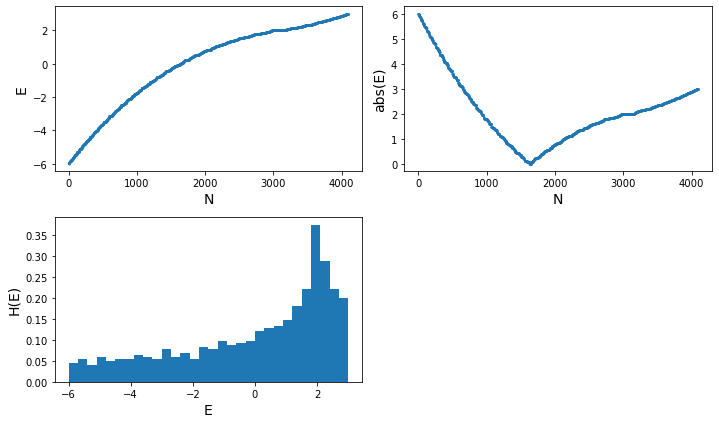

In [19]:
## setting the hopping strength for triangular lattice
tab,taa,tbb = 1.0,1.0,1.0

## create an instance of the class hamiltonian
sysL12 = Hamiltonian(64,tab,taa,tbb)

## set the neighbour table
sysL12.neighbour()

## set the sites into sublattice
sysL12.sublatt_set()

## set up the hamiltonian for the square lattice
mat=np.zeros((sysL12.n_sites,sysL12.n_sites))
sysL12.triangular(mat)

sysL12.evals(mat)
sysL12.plot_eval(30)

### Square lattice using weak hopping


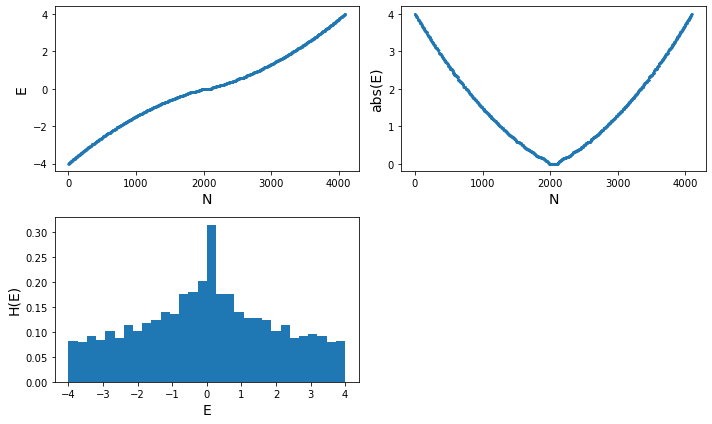

In [20]:
## setting the hopping strength for triangular lattice
tab, taa, tbb = 1.0, 0.001, 0.001

## create an instance of the class hamiltonian
sqrL12 = Hamiltonian(64, tab, taa, tbb)

## set the neighbour table
sqrL12.neighbour()

## set the sites into sublattice
sqrL12.sublatt_set()

## set up the hamiltonian for the square lattice
mat = np.zeros((sqrL12.n_sites, sqrL12.n_sites))
sqrL12.triangular(mat)

sqrL12.evals(mat)
sqrL12.plot_eval(30)


### Honey comb lattice

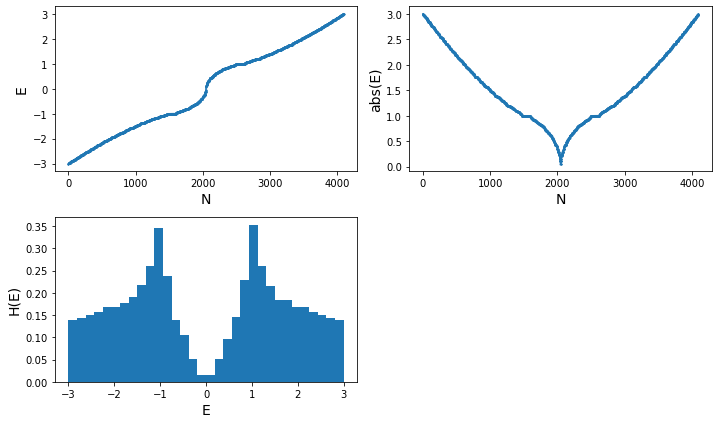

In [21]:
tab,taa,tbb,tdi,tui=1,0.001,0.001,0.001,0.001
hL12 = honeycomb(64,tab,taa,tbb,tdi,tui)
hL12.neighbour()
hL12.sublatt_set()
mat = np.zeros((hL12.n_sites,hL12.n_sites))
hL12.honeycomblatt(mat)
hL12.evals(mat)
hL12.plot_eval()




### Hexagon to square

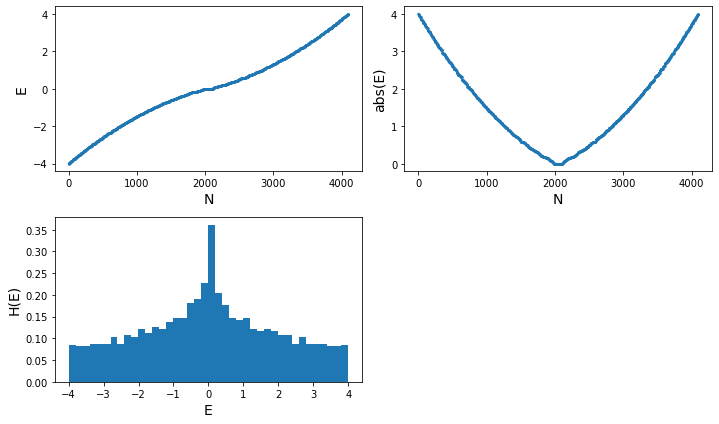

In [22]:
tab, taa, tbb, tdi, tui =  1, 0.001, 0.001, 1, 1
hb12 = honeycomb(64, tab, taa, tbb, tdi, tui)
hb12.neighbour()
hb12.sublatt_set()
mat = np.zeros((hb12.n_sites, hb12.n_sites))
hb12.honeycomblatt(mat)
hb12.evals(mat)
hb12.plot_eval(40)

### Hexagonal to triangle

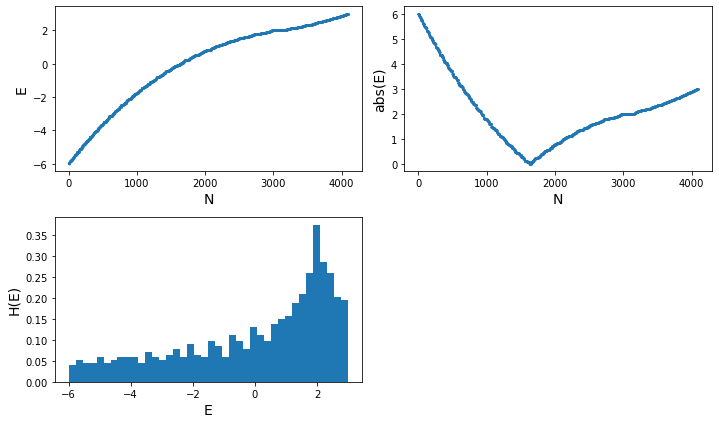

In [23]:
tab, taa, tbb, tdi, tui = 1, 1.0, 1.0, 1, 1
hb12 = honeycomb(64, tab, taa, tbb, tdi, tui)
hb12.neighbour()
hb12.sublatt_set()
mat = np.zeros((hb12.n_sites, hb12.n_sites))
hb12.honeycomblatt(mat)
hb12.evals(mat)
hb12.plot_eval(40)


### Traingle to Kagome 
* The nearest neighbour hopping between site a and site b on odd layer and odd sites are set to zero.
* The next nearest interaction between sublattice a is also set to zero
* While setting all bonds to zero for one particular site one end up creating rows and columns of all zeros and this in turn created more states with zero energy.

In [239]:
def plothammat(a):
    f = plt.figure(figsize=(12, 12))
    ax = sns.heatmap(a, cbar=False, annot=True, fmt='1.0f',
                linewidth=1, linecolor='black')
    ax.xaxis.tick_top()
    plt.show()

kgLatt= kagomeLieb(48,1,0,0)
kgLatt.neighbour()
kgLatt.sublatt_set()
mat = np.zeros((kgLatt.n_sites,kgLatt.n_sites))
kgLatt.triangular(mat)
#plothammat(mat)
kgLatt.triangle_Kagome_lieb(mat,0.0,0.0,1.0)
#plothammat(mat)
#kgLatt.evals(mat) 


taa:0.0 tbb:1.0


array([[ 0., -1.,  0., ...,  0.,  0., -0.],
       [-1.,  0., -1., ...,  0.,  0.,  0.],
       [ 0., -1.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ..., -0.,  0., -0.],
       [-0.,  0.,  0., ...,  0., -0.,  0.]])

In [240]:
listrow = []
listcol = []
for j in range(mat.shape[0]):
     if (mat[j,:].sum()==0):
         listrow.append(j)
     if (mat[:,j].sum()==0):
         listcol.append(j)

listrow.reverse()
listcol.reverse()
#print(listz)
len(listcol)

576

In [241]:
for i in range(10):
    print(f'i:{i} lr{listrow[i]} lc{listcol[i]}')

i:0 lr2303 lc2303
i:1 lr2301 lc2301
i:2 lr2299 lc2299
i:3 lr2297 lc2297
i:4 lr2295 lc2295
i:5 lr2293 lc2293
i:6 lr2291 lc2291
i:7 lr2289 lc2289
i:8 lr2287 lc2287
i:9 lr2285 lc2285


In [242]:
for j in listcol:
    mati=np.delete(mat,j,0)
    mat = mati
for j in listrow:
    mati = np.delete(mat, j, 1)
    mat = mati

#plothammat(mat)
#plothammat(mat)

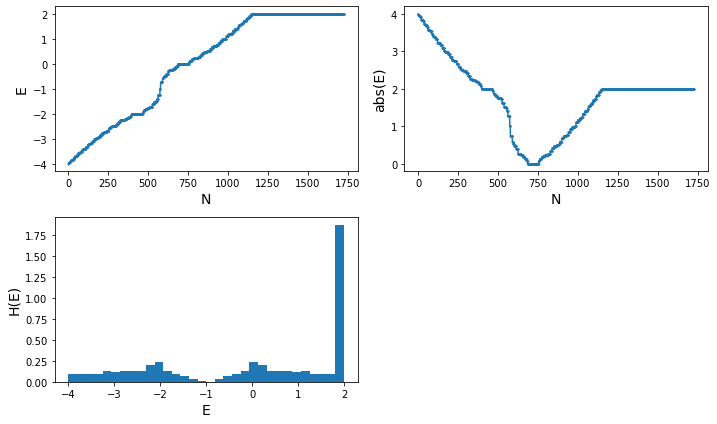

In [243]:
kgLatt.evals(mat)
kgLatt.plot_eval()

In [244]:
np.isclose(kgLatt.eval_i,0).sum()

69

taa:0.01 tbb:0.01


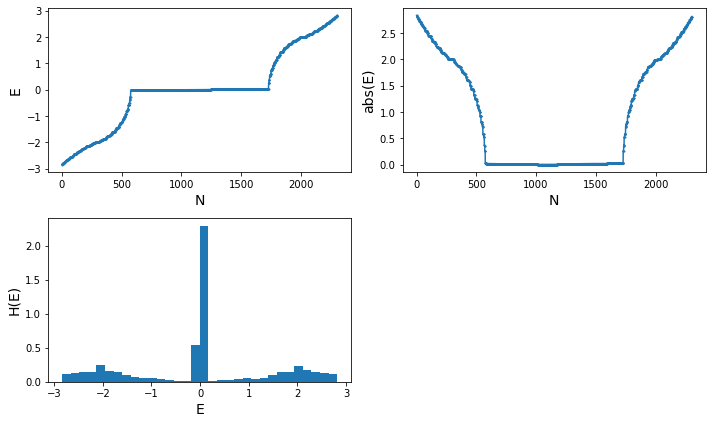

In [159]:
kgLatt = kagomeLieb(48, 1, 0, 0)
kgLatt.neighbour()
kgLatt.sublatt_set()
mat = np.zeros((kgLatt.n_sites, kgLatt.n_sites))
kgLatt.triangular(mat)
kgLatt.triangle_Kagome_lieb(mat, 0.01, 0.01, 0.01)
kgLatt.evals(mat)
kgLatt.plot_eval()
